In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # wrapper
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # addition
    def __add__(self, other):
        sum = Value(self.data + other.data, (self, other), '+')
        
        # backprop for addition
        def _backward():
            # chain rule
            self.grad += 1.0 * sum.grad
            other.grad += 1.0 * sum.grad

        sum._backward = _backward

        return sum
    
    # multiplication
    def __mul__(self, other):
        prod = Value(self.data * other.data, (self, other), '*')
        
    
        #backprop for multiplication
        def _backward():
            # chain rule
            self.grad += other.data * prod.grad
            other.grad += self.data * prod.grad

        prod._backward = _backward

        return prod

    # tanh activation
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        # backprop for tanh
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    
    # ReLU activation
    def ReLU(self):
        if self.data > 0:
            out = Value(self.data, (self,), 'ReLU')

            def _backward():
                self.grad += 1 * out.grad
            
            out._backward = _backward
        
        else:
            out = Value(0, (self, ), 'ReLU')

            def _backward():
                self.grad += 0 * out.grad
            
            out._backward = _backward

        return out
    
    # backprop - topological sort
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)

                topo.append(v)

        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [6]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [7]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88137358, label='b')

# calculations
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

In [8]:
o.backward()

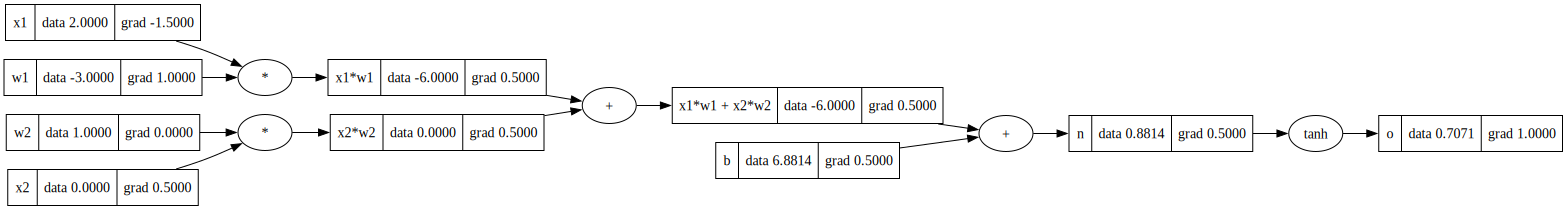

In [9]:
draw(o)

In [10]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# hidden units (weights & biases)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88137358, label='b')

# output bias
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.ReLU(); o.label = 'o'

In [11]:
o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

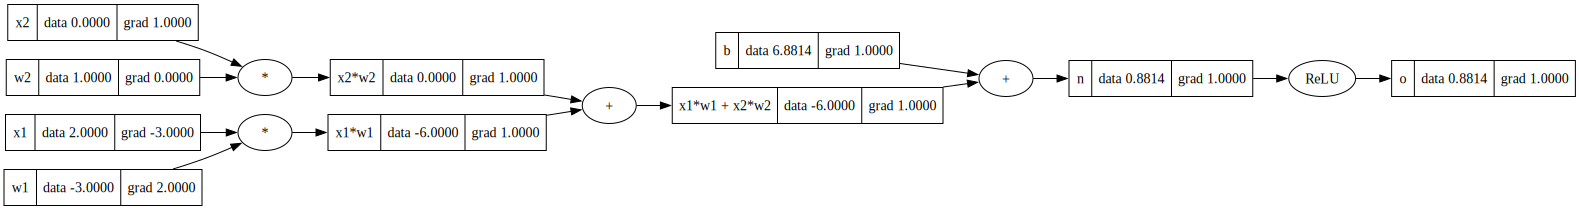

In [12]:
draw(o)

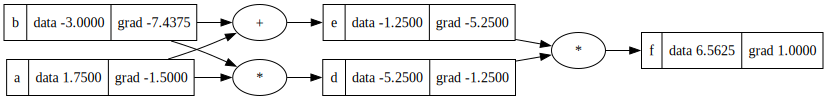

In [13]:
a = Value(1.75, label='a')
b = Value(-3, label = 'b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw(f)